## PyTorch 可视化
- 1、模型结构可视化
- 2、训练过程可视化
- 3、模型评估可视化


In [2]:
#导入 常用包
import os 
import numpy as np 
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
import torchvision

In [8]:
import torch.nn.functional as F
# 自定义model
class DemoModel(nn.Module):
    def __init__(self):
        super(DemoModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [9]:
model = DemoModel()
#方法一：print打印（模型结构可视化）
print(model)

DemoModel(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


### torchinfo
#pip3 install torchinfo 

- trochinfo的使用也是十分简单，我们只需要使用torchinfo.summary()就行了，必需的参数分别是model，input_size[batch_size,channel,h,w]
- 提供了模块信息（每一层的类型、输出shape和参数量）、模型整体的参数量、模型大小、一次前向或者反向传播需要的内存大小等

In [10]:
from torchinfo import summary

In [21]:
model = DemoModel() # 实例化模型
#方法二：torchinfo 查看 模型结构可视化
summary(model, (1, 3, 32, 32)) # 1：batch_size 3:图片的通道数 1024: 图片的高宽

Layer (type:depth-idx)                   Output Shape              Param #
DemoModel                                [1, 10]                   --
├─Conv2d: 1-1                            [1, 6, 28, 28]            456
├─MaxPool2d: 1-2                         [1, 6, 14, 14]            --
├─Conv2d: 1-3                            [1, 16, 10, 10]           2,416
├─MaxPool2d: 1-4                         [1, 16, 5, 5]             --
├─Linear: 1-5                            [1, 120]                  48,120
├─Linear: 1-6                            [1, 84]                   10,164
├─Linear: 1-7                            [1, 10]                   850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
Total mult-adds (M): 0.66
Input size (MB): 0.01
Forward/backward pass size (MB): 0.05
Params size (MB): 0.25
Estimated Total Size (MB): 0.31

### TensorBoard
- TensorBoard作为一款可视化工具能够满足 输入数据（尤其是图片）、模型结构、参数分布、debug的需求
- TensorBoard可以记录我们指定的数据，包括模型每一层的feature map，权重，以及训练loss等等
- 利用TensorBoard实现训练过程可视化

#### 安装
pip3 install tensorboard

#### 启动tensorboard
tensorboard --logdir=/path/to/logs/ --port=xxxx

- 其中“path/to/logs/"是指定的保存tensorboard记录结果的文件路径,等价于上面的“./runs"
- port是外部访问TensorBoard的端口号，可以通过访问ip:port访问tensorboard)

In [13]:
# from tensorboard import SummaryWriter
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('./runs')

In [14]:
print(model)

DemoModel(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [15]:
#方法三：tensorboard查看
writer.add_graph(model,torch.rand(1, 3, 32, 32))
writer.close()

#### tensorboard 可视图
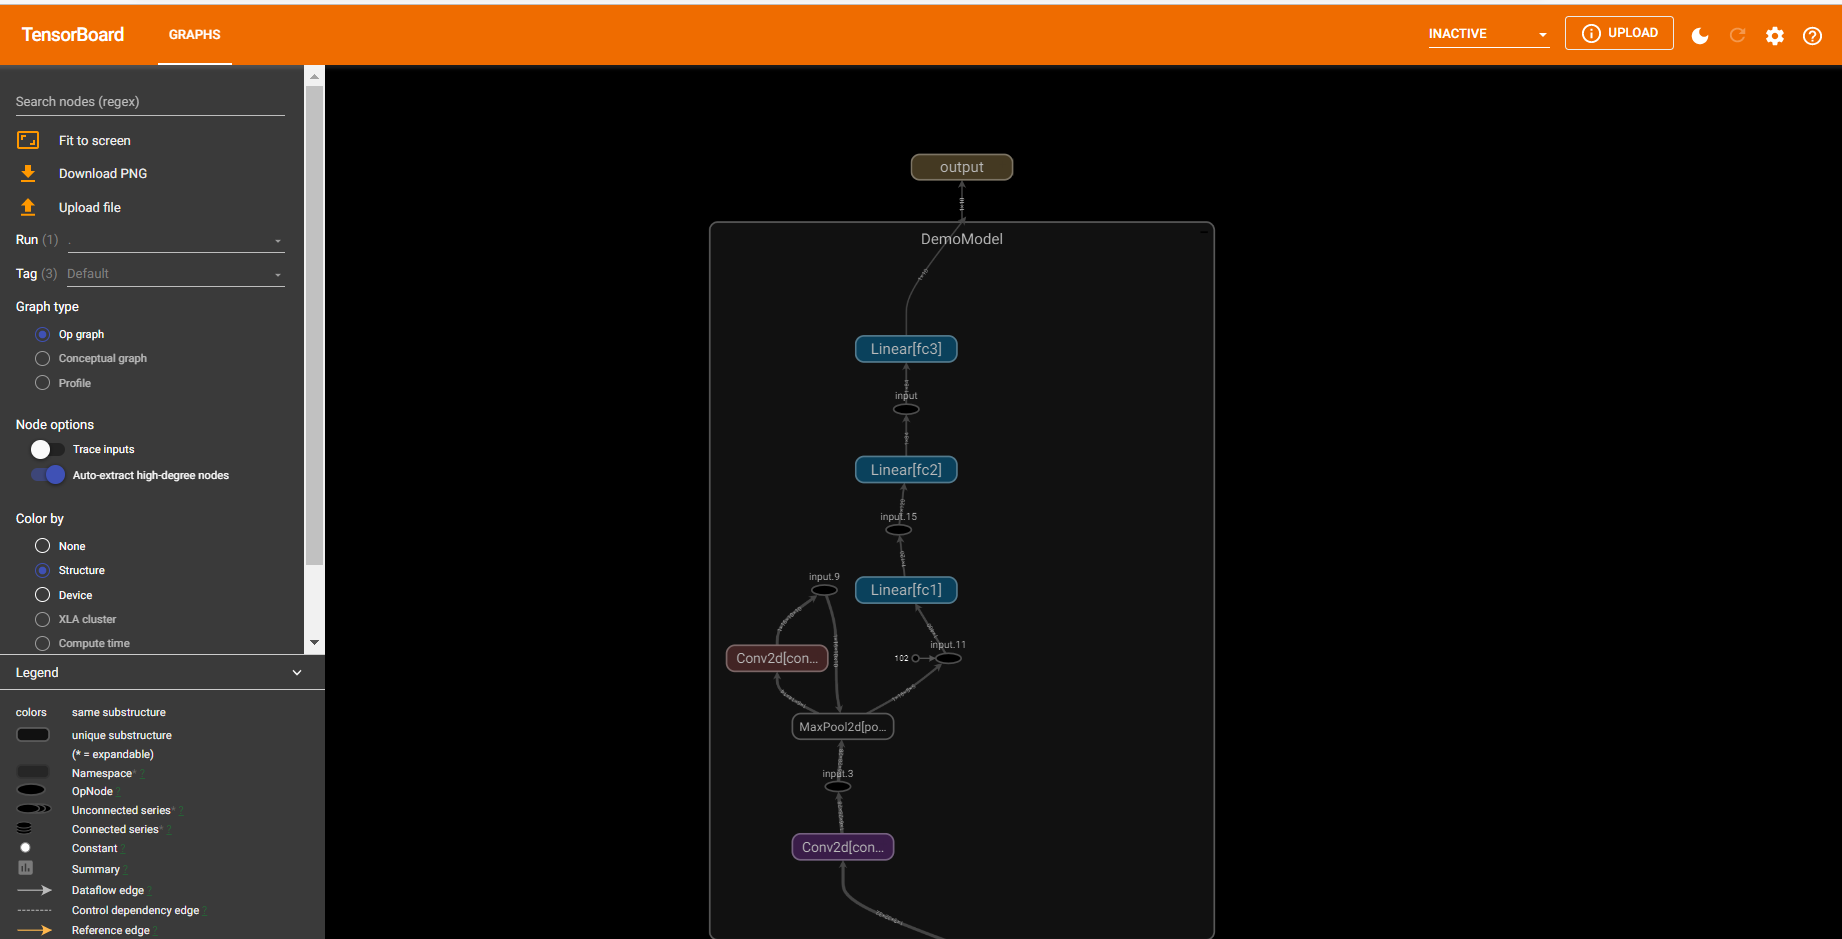

In [19]:
#超参数定义
# 批次的大小
batch_size = 16 #可选32、64、128
# 优化器的学习率
lr = 1e-4
#运行epoch
max_epochs = 2
# 方案一：指定GPU的方式
# os.environ['CUDA_VISIBLE_DEVICES'] = '0,1' # 指明调用的GPU为0,1号

# 方案二：使用“device”，后续对要使用GPU的变量用.to(device)即可
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # 指明调用的GPU为1号

# 数据读取
#cifar10数据集为例给出构建Dataset类的方式
from torchvision import datasets

#“data_transform”可以对图像进行一定的变换，如翻转、裁剪、归一化等操作，可自己定义
data_transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                   ])


train_cifar_dataset = datasets.CIFAR10('cifar10',train=True, download=False,transform=data_transform)
test_cifar_dataset = datasets.CIFAR10('cifar10',train=False, download=False,transform=data_transform)

#构建好Dataset后，就可以使用DataLoader来按批次读入数据了

train_loader = torch.utils.data.DataLoader(train_cifar_dataset, 
                                           batch_size=batch_size, num_workers=4, 
                                           shuffle=True, drop_last=True)

test_loader = torch.utils.data.DataLoader(test_cifar_dataset, 
                                         batch_size=batch_size, num_workers=4, 
                                         shuffle=False)

In [20]:
#训练&验证
writer = SummaryWriter('./runs')
 # Set fixed random number seed
torch.manual_seed(42)
# 定义损失函数和优化器
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
My_model = DemoModel()
My_model = My_model.to(device)
# 交叉熵
criterion = torch.nn.CrossEntropyLoss()
# 优化器
optimizer = torch.optim.Adam(My_model.parameters(), lr=lr)
epoch = max_epochs

total_step = len(train_loader)
train_all_loss = []
test_all_loss = []
for i in range(epoch):
    My_model.train()
    train_total_loss = 0
    train_total_num = 0
    train_total_correct = 0

    for iter, (images,labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Write the network graph at epoch 0, batch 0
        if epoch == 0 and iter == 0:
            writer.add_graph(My_model, input_to_model=(images,labels)[0], verbose=True)

        # Write an image at every batch 0
        if iter == 0:
            writer.add_image("Example input", images[0], global_step=epoch)
        
        outputs = My_model(images)
        loss = criterion(outputs,labels)
        train_total_correct += (outputs.argmax(1) == labels).sum().item()
        #backword
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_total_num += labels.shape[0]
        train_total_loss += loss.item()
        
        # Print statistics
        writer.add_scalar("Loss/Minibatches", train_total_loss, train_total_num)
        
        print("Epoch [{}/{}], Iter [{}/{}], train_loss:{:4f}".format(i+1,epoch,iter+1,total_step,loss.item()/labels.shape[0]))
    
    # Write loss for epoch
    writer.add_scalar("Loss/Epochs", train_total_loss, epoch)
    
    My_model.eval()
    test_total_loss = 0
    test_total_correct = 0
    test_total_num = 0
    for iter,(images,labels) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = My_model(images)
        loss = criterion(outputs,labels)
        test_total_correct += (outputs.argmax(1) == labels).sum().item()
        test_total_loss += loss.item()
        test_total_num += labels.shape[0]
    print("Epoch [{}/{}], train_loss:{:.4f}, train_acc:{:.4f}%, test_loss:{:.4f}, test_acc:{:.4f}%".format(
        i+1, epoch, train_total_loss / train_total_num, train_total_correct / train_total_num * 100, test_total_loss / test_total_num, test_total_correct / test_total_num * 100
    
    ))
    train_all_loss.append(np.round(train_total_loss / train_total_num,4))
    test_all_loss.append(np.round(test_total_loss / test_total_num,4))


Epoch [1/2], Iter [1/3125], train_loss:0.144669
Epoch [1/2], Iter [2/3125], train_loss:0.144400
Epoch [1/2], Iter [3/3125], train_loss:0.142514
Epoch [1/2], Iter [4/3125], train_loss:0.143597
Epoch [1/2], Iter [5/3125], train_loss:0.142685
Epoch [1/2], Iter [6/3125], train_loss:0.145855
Epoch [1/2], Iter [7/3125], train_loss:0.144371
Epoch [1/2], Iter [8/3125], train_loss:0.143802
Epoch [1/2], Iter [9/3125], train_loss:0.144617
Epoch [1/2], Iter [10/3125], train_loss:0.144486
Epoch [1/2], Iter [11/3125], train_loss:0.144596
Epoch [1/2], Iter [12/3125], train_loss:0.142283
Epoch [1/2], Iter [13/3125], train_loss:0.144148
Epoch [1/2], Iter [14/3125], train_loss:0.142947
Epoch [1/2], Iter [15/3125], train_loss:0.144145
Epoch [1/2], Iter [16/3125], train_loss:0.143488
Epoch [1/2], Iter [17/3125], train_loss:0.142643
Epoch [1/2], Iter [18/3125], train_loss:0.146512
Epoch [1/2], Iter [19/3125], train_loss:0.143885
Epoch [1/2], Iter [20/3125], train_loss:0.144233
Epoch [1/2], Iter [21/3125], 

Epoch [1/2], Iter [170/3125], train_loss:0.138041
Epoch [1/2], Iter [171/3125], train_loss:0.140719
Epoch [1/2], Iter [172/3125], train_loss:0.140380
Epoch [1/2], Iter [173/3125], train_loss:0.138292
Epoch [1/2], Iter [174/3125], train_loss:0.139129
Epoch [1/2], Iter [175/3125], train_loss:0.135949
Epoch [1/2], Iter [176/3125], train_loss:0.137600
Epoch [1/2], Iter [177/3125], train_loss:0.141040
Epoch [1/2], Iter [178/3125], train_loss:0.140551
Epoch [1/2], Iter [179/3125], train_loss:0.138928
Epoch [1/2], Iter [180/3125], train_loss:0.138223
Epoch [1/2], Iter [181/3125], train_loss:0.139874
Epoch [1/2], Iter [182/3125], train_loss:0.136038
Epoch [1/2], Iter [183/3125], train_loss:0.139188
Epoch [1/2], Iter [184/3125], train_loss:0.136467
Epoch [1/2], Iter [185/3125], train_loss:0.139826
Epoch [1/2], Iter [186/3125], train_loss:0.139104
Epoch [1/2], Iter [187/3125], train_loss:0.135848
Epoch [1/2], Iter [188/3125], train_loss:0.136343
Epoch [1/2], Iter [189/3125], train_loss:0.136391


Epoch [1/2], Iter [340/3125], train_loss:0.118221
Epoch [1/2], Iter [341/3125], train_loss:0.131340
Epoch [1/2], Iter [342/3125], train_loss:0.119148
Epoch [1/2], Iter [343/3125], train_loss:0.124766
Epoch [1/2], Iter [344/3125], train_loss:0.106605
Epoch [1/2], Iter [345/3125], train_loss:0.131776
Epoch [1/2], Iter [346/3125], train_loss:0.120655
Epoch [1/2], Iter [347/3125], train_loss:0.126747
Epoch [1/2], Iter [348/3125], train_loss:0.119800
Epoch [1/2], Iter [349/3125], train_loss:0.140558
Epoch [1/2], Iter [350/3125], train_loss:0.140993
Epoch [1/2], Iter [351/3125], train_loss:0.117980
Epoch [1/2], Iter [352/3125], train_loss:0.130801
Epoch [1/2], Iter [353/3125], train_loss:0.129439
Epoch [1/2], Iter [354/3125], train_loss:0.124127
Epoch [1/2], Iter [355/3125], train_loss:0.115912
Epoch [1/2], Iter [356/3125], train_loss:0.123453
Epoch [1/2], Iter [357/3125], train_loss:0.129604
Epoch [1/2], Iter [358/3125], train_loss:0.130809
Epoch [1/2], Iter [359/3125], train_loss:0.131867


Epoch [1/2], Iter [505/3125], train_loss:0.119228
Epoch [1/2], Iter [506/3125], train_loss:0.127352
Epoch [1/2], Iter [507/3125], train_loss:0.115622
Epoch [1/2], Iter [508/3125], train_loss:0.127789
Epoch [1/2], Iter [509/3125], train_loss:0.120047
Epoch [1/2], Iter [510/3125], train_loss:0.124719
Epoch [1/2], Iter [511/3125], train_loss:0.129351
Epoch [1/2], Iter [512/3125], train_loss:0.121679
Epoch [1/2], Iter [513/3125], train_loss:0.114047
Epoch [1/2], Iter [514/3125], train_loss:0.127208
Epoch [1/2], Iter [515/3125], train_loss:0.121441
Epoch [1/2], Iter [516/3125], train_loss:0.107704
Epoch [1/2], Iter [517/3125], train_loss:0.115318
Epoch [1/2], Iter [518/3125], train_loss:0.123255
Epoch [1/2], Iter [519/3125], train_loss:0.117331
Epoch [1/2], Iter [520/3125], train_loss:0.129735
Epoch [1/2], Iter [521/3125], train_loss:0.121294
Epoch [1/2], Iter [522/3125], train_loss:0.132048
Epoch [1/2], Iter [523/3125], train_loss:0.122887
Epoch [1/2], Iter [524/3125], train_loss:0.131852


Epoch [1/2], Iter [670/3125], train_loss:0.121239
Epoch [1/2], Iter [671/3125], train_loss:0.123629
Epoch [1/2], Iter [672/3125], train_loss:0.125129
Epoch [1/2], Iter [673/3125], train_loss:0.116211
Epoch [1/2], Iter [674/3125], train_loss:0.132116
Epoch [1/2], Iter [675/3125], train_loss:0.110754
Epoch [1/2], Iter [676/3125], train_loss:0.128632
Epoch [1/2], Iter [677/3125], train_loss:0.119124
Epoch [1/2], Iter [678/3125], train_loss:0.130263
Epoch [1/2], Iter [679/3125], train_loss:0.120960
Epoch [1/2], Iter [680/3125], train_loss:0.132982
Epoch [1/2], Iter [681/3125], train_loss:0.114149
Epoch [1/2], Iter [682/3125], train_loss:0.109227
Epoch [1/2], Iter [683/3125], train_loss:0.118230
Epoch [1/2], Iter [684/3125], train_loss:0.116969
Epoch [1/2], Iter [685/3125], train_loss:0.138058
Epoch [1/2], Iter [686/3125], train_loss:0.128153
Epoch [1/2], Iter [687/3125], train_loss:0.131903
Epoch [1/2], Iter [688/3125], train_loss:0.132101
Epoch [1/2], Iter [689/3125], train_loss:0.108870


Epoch [1/2], Iter [847/3125], train_loss:0.124381
Epoch [1/2], Iter [848/3125], train_loss:0.116811
Epoch [1/2], Iter [849/3125], train_loss:0.111022
Epoch [1/2], Iter [850/3125], train_loss:0.113673
Epoch [1/2], Iter [851/3125], train_loss:0.118748
Epoch [1/2], Iter [852/3125], train_loss:0.107792
Epoch [1/2], Iter [853/3125], train_loss:0.091750
Epoch [1/2], Iter [854/3125], train_loss:0.117189
Epoch [1/2], Iter [855/3125], train_loss:0.103564
Epoch [1/2], Iter [856/3125], train_loss:0.107830
Epoch [1/2], Iter [857/3125], train_loss:0.117412
Epoch [1/2], Iter [858/3125], train_loss:0.119463
Epoch [1/2], Iter [859/3125], train_loss:0.113894
Epoch [1/2], Iter [860/3125], train_loss:0.115058
Epoch [1/2], Iter [861/3125], train_loss:0.118089
Epoch [1/2], Iter [862/3125], train_loss:0.113438
Epoch [1/2], Iter [863/3125], train_loss:0.111699
Epoch [1/2], Iter [864/3125], train_loss:0.102189
Epoch [1/2], Iter [865/3125], train_loss:0.103186
Epoch [1/2], Iter [866/3125], train_loss:0.100461


Epoch [1/2], Iter [1023/3125], train_loss:0.133845
Epoch [1/2], Iter [1024/3125], train_loss:0.122334
Epoch [1/2], Iter [1025/3125], train_loss:0.118223
Epoch [1/2], Iter [1026/3125], train_loss:0.117360
Epoch [1/2], Iter [1027/3125], train_loss:0.107894
Epoch [1/2], Iter [1028/3125], train_loss:0.133769
Epoch [1/2], Iter [1029/3125], train_loss:0.110530
Epoch [1/2], Iter [1030/3125], train_loss:0.123929
Epoch [1/2], Iter [1031/3125], train_loss:0.111092
Epoch [1/2], Iter [1032/3125], train_loss:0.120122
Epoch [1/2], Iter [1033/3125], train_loss:0.121327
Epoch [1/2], Iter [1034/3125], train_loss:0.112605
Epoch [1/2], Iter [1035/3125], train_loss:0.115653
Epoch [1/2], Iter [1036/3125], train_loss:0.132838
Epoch [1/2], Iter [1037/3125], train_loss:0.146219
Epoch [1/2], Iter [1038/3125], train_loss:0.096832
Epoch [1/2], Iter [1039/3125], train_loss:0.099740
Epoch [1/2], Iter [1040/3125], train_loss:0.133769
Epoch [1/2], Iter [1041/3125], train_loss:0.123352
Epoch [1/2], Iter [1042/3125], 

Epoch [1/2], Iter [1187/3125], train_loss:0.111751
Epoch [1/2], Iter [1188/3125], train_loss:0.121170
Epoch [1/2], Iter [1189/3125], train_loss:0.093892
Epoch [1/2], Iter [1190/3125], train_loss:0.118568
Epoch [1/2], Iter [1191/3125], train_loss:0.109708
Epoch [1/2], Iter [1192/3125], train_loss:0.123061
Epoch [1/2], Iter [1193/3125], train_loss:0.109314
Epoch [1/2], Iter [1194/3125], train_loss:0.091948
Epoch [1/2], Iter [1195/3125], train_loss:0.099744
Epoch [1/2], Iter [1196/3125], train_loss:0.108249
Epoch [1/2], Iter [1197/3125], train_loss:0.116611
Epoch [1/2], Iter [1198/3125], train_loss:0.117035
Epoch [1/2], Iter [1199/3125], train_loss:0.126182
Epoch [1/2], Iter [1200/3125], train_loss:0.113142
Epoch [1/2], Iter [1201/3125], train_loss:0.138034
Epoch [1/2], Iter [1202/3125], train_loss:0.124534
Epoch [1/2], Iter [1203/3125], train_loss:0.121741
Epoch [1/2], Iter [1204/3125], train_loss:0.134622
Epoch [1/2], Iter [1205/3125], train_loss:0.124746
Epoch [1/2], Iter [1206/3125], 

Epoch [1/2], Iter [1354/3125], train_loss:0.123291
Epoch [1/2], Iter [1355/3125], train_loss:0.122079
Epoch [1/2], Iter [1356/3125], train_loss:0.122843
Epoch [1/2], Iter [1357/3125], train_loss:0.106878
Epoch [1/2], Iter [1358/3125], train_loss:0.124058
Epoch [1/2], Iter [1359/3125], train_loss:0.115362
Epoch [1/2], Iter [1360/3125], train_loss:0.098164
Epoch [1/2], Iter [1361/3125], train_loss:0.105819
Epoch [1/2], Iter [1362/3125], train_loss:0.104920
Epoch [1/2], Iter [1363/3125], train_loss:0.124217
Epoch [1/2], Iter [1364/3125], train_loss:0.104251
Epoch [1/2], Iter [1365/3125], train_loss:0.095865
Epoch [1/2], Iter [1366/3125], train_loss:0.089077
Epoch [1/2], Iter [1367/3125], train_loss:0.126124
Epoch [1/2], Iter [1368/3125], train_loss:0.122969
Epoch [1/2], Iter [1369/3125], train_loss:0.113256
Epoch [1/2], Iter [1370/3125], train_loss:0.102899
Epoch [1/2], Iter [1371/3125], train_loss:0.127852
Epoch [1/2], Iter [1372/3125], train_loss:0.105047
Epoch [1/2], Iter [1373/3125], 

Epoch [1/2], Iter [1516/3125], train_loss:0.116042
Epoch [1/2], Iter [1517/3125], train_loss:0.130301
Epoch [1/2], Iter [1518/3125], train_loss:0.136893
Epoch [1/2], Iter [1519/3125], train_loss:0.101100
Epoch [1/2], Iter [1520/3125], train_loss:0.103681
Epoch [1/2], Iter [1521/3125], train_loss:0.123037
Epoch [1/2], Iter [1522/3125], train_loss:0.093634
Epoch [1/2], Iter [1523/3125], train_loss:0.109460
Epoch [1/2], Iter [1524/3125], train_loss:0.109647
Epoch [1/2], Iter [1525/3125], train_loss:0.115037
Epoch [1/2], Iter [1526/3125], train_loss:0.120785
Epoch [1/2], Iter [1527/3125], train_loss:0.126564
Epoch [1/2], Iter [1528/3125], train_loss:0.114931
Epoch [1/2], Iter [1529/3125], train_loss:0.108261
Epoch [1/2], Iter [1530/3125], train_loss:0.098192
Epoch [1/2], Iter [1531/3125], train_loss:0.090767
Epoch [1/2], Iter [1532/3125], train_loss:0.101784
Epoch [1/2], Iter [1533/3125], train_loss:0.088759
Epoch [1/2], Iter [1534/3125], train_loss:0.116256
Epoch [1/2], Iter [1535/3125], 

Epoch [1/2], Iter [1689/3125], train_loss:0.094978
Epoch [1/2], Iter [1690/3125], train_loss:0.097795
Epoch [1/2], Iter [1691/3125], train_loss:0.120753
Epoch [1/2], Iter [1692/3125], train_loss:0.115691
Epoch [1/2], Iter [1693/3125], train_loss:0.120680
Epoch [1/2], Iter [1694/3125], train_loss:0.115340
Epoch [1/2], Iter [1695/3125], train_loss:0.092803
Epoch [1/2], Iter [1696/3125], train_loss:0.120834
Epoch [1/2], Iter [1697/3125], train_loss:0.108084
Epoch [1/2], Iter [1698/3125], train_loss:0.101212
Epoch [1/2], Iter [1699/3125], train_loss:0.108573
Epoch [1/2], Iter [1700/3125], train_loss:0.093530
Epoch [1/2], Iter [1701/3125], train_loss:0.101193
Epoch [1/2], Iter [1702/3125], train_loss:0.125252
Epoch [1/2], Iter [1703/3125], train_loss:0.120730
Epoch [1/2], Iter [1704/3125], train_loss:0.089746
Epoch [1/2], Iter [1705/3125], train_loss:0.084218
Epoch [1/2], Iter [1706/3125], train_loss:0.086580
Epoch [1/2], Iter [1707/3125], train_loss:0.116603
Epoch [1/2], Iter [1708/3125], 

Epoch [1/2], Iter [1852/3125], train_loss:0.107665
Epoch [1/2], Iter [1853/3125], train_loss:0.144160
Epoch [1/2], Iter [1854/3125], train_loss:0.115437
Epoch [1/2], Iter [1855/3125], train_loss:0.110849
Epoch [1/2], Iter [1856/3125], train_loss:0.128062
Epoch [1/2], Iter [1857/3125], train_loss:0.105805
Epoch [1/2], Iter [1858/3125], train_loss:0.086202
Epoch [1/2], Iter [1859/3125], train_loss:0.092168
Epoch [1/2], Iter [1860/3125], train_loss:0.086430
Epoch [1/2], Iter [1861/3125], train_loss:0.142549
Epoch [1/2], Iter [1862/3125], train_loss:0.106225
Epoch [1/2], Iter [1863/3125], train_loss:0.096040
Epoch [1/2], Iter [1864/3125], train_loss:0.120866
Epoch [1/2], Iter [1865/3125], train_loss:0.088266
Epoch [1/2], Iter [1866/3125], train_loss:0.104085
Epoch [1/2], Iter [1867/3125], train_loss:0.094867
Epoch [1/2], Iter [1868/3125], train_loss:0.131486
Epoch [1/2], Iter [1869/3125], train_loss:0.116555
Epoch [1/2], Iter [1870/3125], train_loss:0.124041
Epoch [1/2], Iter [1871/3125], 

Epoch [1/2], Iter [2023/3125], train_loss:0.145143
Epoch [1/2], Iter [2024/3125], train_loss:0.102923
Epoch [1/2], Iter [2025/3125], train_loss:0.108920
Epoch [1/2], Iter [2026/3125], train_loss:0.130747
Epoch [1/2], Iter [2027/3125], train_loss:0.103417
Epoch [1/2], Iter [2028/3125], train_loss:0.098614
Epoch [1/2], Iter [2029/3125], train_loss:0.105455
Epoch [1/2], Iter [2030/3125], train_loss:0.119519
Epoch [1/2], Iter [2031/3125], train_loss:0.150184
Epoch [1/2], Iter [2032/3125], train_loss:0.099147
Epoch [1/2], Iter [2033/3125], train_loss:0.098215
Epoch [1/2], Iter [2034/3125], train_loss:0.112823
Epoch [1/2], Iter [2035/3125], train_loss:0.085810
Epoch [1/2], Iter [2036/3125], train_loss:0.117280
Epoch [1/2], Iter [2037/3125], train_loss:0.092518
Epoch [1/2], Iter [2038/3125], train_loss:0.119543
Epoch [1/2], Iter [2039/3125], train_loss:0.093141
Epoch [1/2], Iter [2040/3125], train_loss:0.120413
Epoch [1/2], Iter [2041/3125], train_loss:0.114774
Epoch [1/2], Iter [2042/3125], 

Epoch [1/2], Iter [2194/3125], train_loss:0.089179
Epoch [1/2], Iter [2195/3125], train_loss:0.110558
Epoch [1/2], Iter [2196/3125], train_loss:0.111006
Epoch [1/2], Iter [2197/3125], train_loss:0.127847
Epoch [1/2], Iter [2198/3125], train_loss:0.128473
Epoch [1/2], Iter [2199/3125], train_loss:0.103485
Epoch [1/2], Iter [2200/3125], train_loss:0.095090
Epoch [1/2], Iter [2201/3125], train_loss:0.097227
Epoch [1/2], Iter [2202/3125], train_loss:0.087432
Epoch [1/2], Iter [2203/3125], train_loss:0.105471
Epoch [1/2], Iter [2204/3125], train_loss:0.092775
Epoch [1/2], Iter [2205/3125], train_loss:0.103042
Epoch [1/2], Iter [2206/3125], train_loss:0.106584
Epoch [1/2], Iter [2207/3125], train_loss:0.105296
Epoch [1/2], Iter [2208/3125], train_loss:0.105114
Epoch [1/2], Iter [2209/3125], train_loss:0.078274
Epoch [1/2], Iter [2210/3125], train_loss:0.109493
Epoch [1/2], Iter [2211/3125], train_loss:0.100743
Epoch [1/2], Iter [2212/3125], train_loss:0.107156
Epoch [1/2], Iter [2213/3125], 

Epoch [1/2], Iter [2359/3125], train_loss:0.104768
Epoch [1/2], Iter [2360/3125], train_loss:0.098219
Epoch [1/2], Iter [2361/3125], train_loss:0.112216
Epoch [1/2], Iter [2362/3125], train_loss:0.092426
Epoch [1/2], Iter [2363/3125], train_loss:0.128537
Epoch [1/2], Iter [2364/3125], train_loss:0.115459
Epoch [1/2], Iter [2365/3125], train_loss:0.125649
Epoch [1/2], Iter [2366/3125], train_loss:0.103512
Epoch [1/2], Iter [2367/3125], train_loss:0.131236
Epoch [1/2], Iter [2368/3125], train_loss:0.121446
Epoch [1/2], Iter [2369/3125], train_loss:0.090733
Epoch [1/2], Iter [2370/3125], train_loss:0.098224
Epoch [1/2], Iter [2371/3125], train_loss:0.104150
Epoch [1/2], Iter [2372/3125], train_loss:0.099435
Epoch [1/2], Iter [2373/3125], train_loss:0.101091
Epoch [1/2], Iter [2374/3125], train_loss:0.082944
Epoch [1/2], Iter [2375/3125], train_loss:0.132932
Epoch [1/2], Iter [2376/3125], train_loss:0.090348
Epoch [1/2], Iter [2377/3125], train_loss:0.111966
Epoch [1/2], Iter [2378/3125], 

Epoch [1/2], Iter [2537/3125], train_loss:0.110591
Epoch [1/2], Iter [2538/3125], train_loss:0.109879
Epoch [1/2], Iter [2539/3125], train_loss:0.091319
Epoch [1/2], Iter [2540/3125], train_loss:0.126695
Epoch [1/2], Iter [2541/3125], train_loss:0.106647
Epoch [1/2], Iter [2542/3125], train_loss:0.099467
Epoch [1/2], Iter [2543/3125], train_loss:0.083373
Epoch [1/2], Iter [2544/3125], train_loss:0.093541
Epoch [1/2], Iter [2545/3125], train_loss:0.088160
Epoch [1/2], Iter [2546/3125], train_loss:0.119889
Epoch [1/2], Iter [2547/3125], train_loss:0.104679
Epoch [1/2], Iter [2548/3125], train_loss:0.100089
Epoch [1/2], Iter [2549/3125], train_loss:0.079946
Epoch [1/2], Iter [2550/3125], train_loss:0.079817
Epoch [1/2], Iter [2551/3125], train_loss:0.087726
Epoch [1/2], Iter [2552/3125], train_loss:0.098015
Epoch [1/2], Iter [2553/3125], train_loss:0.124803
Epoch [1/2], Iter [2554/3125], train_loss:0.097312
Epoch [1/2], Iter [2555/3125], train_loss:0.115991
Epoch [1/2], Iter [2556/3125], 

Epoch [1/2], Iter [2702/3125], train_loss:0.114327
Epoch [1/2], Iter [2703/3125], train_loss:0.098464
Epoch [1/2], Iter [2704/3125], train_loss:0.117301
Epoch [1/2], Iter [2705/3125], train_loss:0.110901
Epoch [1/2], Iter [2706/3125], train_loss:0.087756
Epoch [1/2], Iter [2707/3125], train_loss:0.081962
Epoch [1/2], Iter [2708/3125], train_loss:0.118143
Epoch [1/2], Iter [2709/3125], train_loss:0.103229
Epoch [1/2], Iter [2710/3125], train_loss:0.099337
Epoch [1/2], Iter [2711/3125], train_loss:0.113719
Epoch [1/2], Iter [2712/3125], train_loss:0.118541
Epoch [1/2], Iter [2713/3125], train_loss:0.092798
Epoch [1/2], Iter [2714/3125], train_loss:0.104246
Epoch [1/2], Iter [2715/3125], train_loss:0.109741
Epoch [1/2], Iter [2716/3125], train_loss:0.085637
Epoch [1/2], Iter [2717/3125], train_loss:0.108858
Epoch [1/2], Iter [2718/3125], train_loss:0.104339
Epoch [1/2], Iter [2719/3125], train_loss:0.106666
Epoch [1/2], Iter [2720/3125], train_loss:0.114349
Epoch [1/2], Iter [2721/3125], 

Epoch [1/2], Iter [2870/3125], train_loss:0.089499
Epoch [1/2], Iter [2871/3125], train_loss:0.116838
Epoch [1/2], Iter [2872/3125], train_loss:0.094077
Epoch [1/2], Iter [2873/3125], train_loss:0.086900
Epoch [1/2], Iter [2874/3125], train_loss:0.120456
Epoch [1/2], Iter [2875/3125], train_loss:0.105262
Epoch [1/2], Iter [2876/3125], train_loss:0.104503
Epoch [1/2], Iter [2877/3125], train_loss:0.090551
Epoch [1/2], Iter [2878/3125], train_loss:0.091151
Epoch [1/2], Iter [2879/3125], train_loss:0.122202
Epoch [1/2], Iter [2880/3125], train_loss:0.120218
Epoch [1/2], Iter [2881/3125], train_loss:0.113807
Epoch [1/2], Iter [2882/3125], train_loss:0.120132
Epoch [1/2], Iter [2883/3125], train_loss:0.082290
Epoch [1/2], Iter [2884/3125], train_loss:0.089505
Epoch [1/2], Iter [2885/3125], train_loss:0.103574
Epoch [1/2], Iter [2886/3125], train_loss:0.132527
Epoch [1/2], Iter [2887/3125], train_loss:0.100686
Epoch [1/2], Iter [2888/3125], train_loss:0.126915
Epoch [1/2], Iter [2889/3125], 

Epoch [1/2], Iter [3048/3125], train_loss:0.107414
Epoch [1/2], Iter [3049/3125], train_loss:0.105963
Epoch [1/2], Iter [3050/3125], train_loss:0.076901
Epoch [1/2], Iter [3051/3125], train_loss:0.080591
Epoch [1/2], Iter [3052/3125], train_loss:0.102428
Epoch [1/2], Iter [3053/3125], train_loss:0.091556
Epoch [1/2], Iter [3054/3125], train_loss:0.111675
Epoch [1/2], Iter [3055/3125], train_loss:0.107065
Epoch [1/2], Iter [3056/3125], train_loss:0.085986
Epoch [1/2], Iter [3057/3125], train_loss:0.093936
Epoch [1/2], Iter [3058/3125], train_loss:0.092470
Epoch [1/2], Iter [3059/3125], train_loss:0.107831
Epoch [1/2], Iter [3060/3125], train_loss:0.096541
Epoch [1/2], Iter [3061/3125], train_loss:0.102824
Epoch [1/2], Iter [3062/3125], train_loss:0.128548
Epoch [1/2], Iter [3063/3125], train_loss:0.095155
Epoch [1/2], Iter [3064/3125], train_loss:0.099371
Epoch [1/2], Iter [3065/3125], train_loss:0.077817
Epoch [1/2], Iter [3066/3125], train_loss:0.097775
Epoch [1/2], Iter [3067/3125], 

Epoch [2/2], Iter [92/3125], train_loss:0.122218
Epoch [2/2], Iter [93/3125], train_loss:0.106616
Epoch [2/2], Iter [94/3125], train_loss:0.111019
Epoch [2/2], Iter [95/3125], train_loss:0.118755
Epoch [2/2], Iter [96/3125], train_loss:0.076335
Epoch [2/2], Iter [97/3125], train_loss:0.104151
Epoch [2/2], Iter [98/3125], train_loss:0.098532
Epoch [2/2], Iter [99/3125], train_loss:0.111462
Epoch [2/2], Iter [100/3125], train_loss:0.089606
Epoch [2/2], Iter [101/3125], train_loss:0.083002
Epoch [2/2], Iter [102/3125], train_loss:0.112811
Epoch [2/2], Iter [103/3125], train_loss:0.104816
Epoch [2/2], Iter [104/3125], train_loss:0.090506
Epoch [2/2], Iter [105/3125], train_loss:0.086553
Epoch [2/2], Iter [106/3125], train_loss:0.085114
Epoch [2/2], Iter [107/3125], train_loss:0.110645
Epoch [2/2], Iter [108/3125], train_loss:0.104584
Epoch [2/2], Iter [109/3125], train_loss:0.119061
Epoch [2/2], Iter [110/3125], train_loss:0.076294
Epoch [2/2], Iter [111/3125], train_loss:0.138477
Epoch [2

Epoch [2/2], Iter [258/3125], train_loss:0.136575
Epoch [2/2], Iter [259/3125], train_loss:0.136308
Epoch [2/2], Iter [260/3125], train_loss:0.093927
Epoch [2/2], Iter [261/3125], train_loss:0.101982
Epoch [2/2], Iter [262/3125], train_loss:0.113312
Epoch [2/2], Iter [263/3125], train_loss:0.112370
Epoch [2/2], Iter [264/3125], train_loss:0.110396
Epoch [2/2], Iter [265/3125], train_loss:0.121290
Epoch [2/2], Iter [266/3125], train_loss:0.093591
Epoch [2/2], Iter [267/3125], train_loss:0.101448
Epoch [2/2], Iter [268/3125], train_loss:0.096478
Epoch [2/2], Iter [269/3125], train_loss:0.082459
Epoch [2/2], Iter [270/3125], train_loss:0.083727
Epoch [2/2], Iter [271/3125], train_loss:0.095732
Epoch [2/2], Iter [272/3125], train_loss:0.082588
Epoch [2/2], Iter [273/3125], train_loss:0.096900
Epoch [2/2], Iter [274/3125], train_loss:0.127659
Epoch [2/2], Iter [275/3125], train_loss:0.070599
Epoch [2/2], Iter [276/3125], train_loss:0.103375
Epoch [2/2], Iter [277/3125], train_loss:0.111102


Epoch [2/2], Iter [431/3125], train_loss:0.089261
Epoch [2/2], Iter [432/3125], train_loss:0.075941
Epoch [2/2], Iter [433/3125], train_loss:0.094041
Epoch [2/2], Iter [434/3125], train_loss:0.101127
Epoch [2/2], Iter [435/3125], train_loss:0.106451
Epoch [2/2], Iter [436/3125], train_loss:0.075778
Epoch [2/2], Iter [437/3125], train_loss:0.089172
Epoch [2/2], Iter [438/3125], train_loss:0.068004
Epoch [2/2], Iter [439/3125], train_loss:0.105840
Epoch [2/2], Iter [440/3125], train_loss:0.090673
Epoch [2/2], Iter [441/3125], train_loss:0.080902
Epoch [2/2], Iter [442/3125], train_loss:0.121756
Epoch [2/2], Iter [443/3125], train_loss:0.111560
Epoch [2/2], Iter [444/3125], train_loss:0.098425
Epoch [2/2], Iter [445/3125], train_loss:0.073100
Epoch [2/2], Iter [446/3125], train_loss:0.083621
Epoch [2/2], Iter [447/3125], train_loss:0.097842
Epoch [2/2], Iter [448/3125], train_loss:0.127285
Epoch [2/2], Iter [449/3125], train_loss:0.095006
Epoch [2/2], Iter [450/3125], train_loss:0.114631


Epoch [2/2], Iter [610/3125], train_loss:0.073314
Epoch [2/2], Iter [611/3125], train_loss:0.088289
Epoch [2/2], Iter [612/3125], train_loss:0.110698
Epoch [2/2], Iter [613/3125], train_loss:0.115269
Epoch [2/2], Iter [614/3125], train_loss:0.088939
Epoch [2/2], Iter [615/3125], train_loss:0.080526
Epoch [2/2], Iter [616/3125], train_loss:0.093740
Epoch [2/2], Iter [617/3125], train_loss:0.097088
Epoch [2/2], Iter [618/3125], train_loss:0.109387
Epoch [2/2], Iter [619/3125], train_loss:0.104509
Epoch [2/2], Iter [620/3125], train_loss:0.091010
Epoch [2/2], Iter [621/3125], train_loss:0.096805
Epoch [2/2], Iter [622/3125], train_loss:0.089015
Epoch [2/2], Iter [623/3125], train_loss:0.089770
Epoch [2/2], Iter [624/3125], train_loss:0.109789
Epoch [2/2], Iter [625/3125], train_loss:0.122831
Epoch [2/2], Iter [626/3125], train_loss:0.103258
Epoch [2/2], Iter [627/3125], train_loss:0.091051
Epoch [2/2], Iter [628/3125], train_loss:0.097646
Epoch [2/2], Iter [629/3125], train_loss:0.100030


Epoch [2/2], Iter [790/3125], train_loss:0.083173
Epoch [2/2], Iter [791/3125], train_loss:0.101334
Epoch [2/2], Iter [792/3125], train_loss:0.084476
Epoch [2/2], Iter [793/3125], train_loss:0.094346
Epoch [2/2], Iter [794/3125], train_loss:0.105841
Epoch [2/2], Iter [795/3125], train_loss:0.091395
Epoch [2/2], Iter [796/3125], train_loss:0.084515
Epoch [2/2], Iter [797/3125], train_loss:0.101325
Epoch [2/2], Iter [798/3125], train_loss:0.099770
Epoch [2/2], Iter [799/3125], train_loss:0.087210
Epoch [2/2], Iter [800/3125], train_loss:0.101003
Epoch [2/2], Iter [801/3125], train_loss:0.092205
Epoch [2/2], Iter [802/3125], train_loss:0.110349
Epoch [2/2], Iter [803/3125], train_loss:0.089687
Epoch [2/2], Iter [804/3125], train_loss:0.119636
Epoch [2/2], Iter [805/3125], train_loss:0.087608
Epoch [2/2], Iter [806/3125], train_loss:0.127233
Epoch [2/2], Iter [807/3125], train_loss:0.093765
Epoch [2/2], Iter [808/3125], train_loss:0.109900
Epoch [2/2], Iter [809/3125], train_loss:0.095428


Epoch [2/2], Iter [973/3125], train_loss:0.118697
Epoch [2/2], Iter [974/3125], train_loss:0.105909
Epoch [2/2], Iter [975/3125], train_loss:0.120023
Epoch [2/2], Iter [976/3125], train_loss:0.066136
Epoch [2/2], Iter [977/3125], train_loss:0.112508
Epoch [2/2], Iter [978/3125], train_loss:0.116231
Epoch [2/2], Iter [979/3125], train_loss:0.113663
Epoch [2/2], Iter [980/3125], train_loss:0.103834
Epoch [2/2], Iter [981/3125], train_loss:0.107557
Epoch [2/2], Iter [982/3125], train_loss:0.094248
Epoch [2/2], Iter [983/3125], train_loss:0.090689
Epoch [2/2], Iter [984/3125], train_loss:0.127976
Epoch [2/2], Iter [985/3125], train_loss:0.080711
Epoch [2/2], Iter [986/3125], train_loss:0.092032
Epoch [2/2], Iter [987/3125], train_loss:0.101075
Epoch [2/2], Iter [988/3125], train_loss:0.112760
Epoch [2/2], Iter [989/3125], train_loss:0.104243
Epoch [2/2], Iter [990/3125], train_loss:0.086584
Epoch [2/2], Iter [991/3125], train_loss:0.102640
Epoch [2/2], Iter [992/3125], train_loss:0.072684


Epoch [2/2], Iter [1138/3125], train_loss:0.102578
Epoch [2/2], Iter [1139/3125], train_loss:0.087307
Epoch [2/2], Iter [1140/3125], train_loss:0.095952
Epoch [2/2], Iter [1141/3125], train_loss:0.090597
Epoch [2/2], Iter [1142/3125], train_loss:0.090445
Epoch [2/2], Iter [1143/3125], train_loss:0.088472
Epoch [2/2], Iter [1144/3125], train_loss:0.095283
Epoch [2/2], Iter [1145/3125], train_loss:0.107986
Epoch [2/2], Iter [1146/3125], train_loss:0.103938
Epoch [2/2], Iter [1147/3125], train_loss:0.106025
Epoch [2/2], Iter [1148/3125], train_loss:0.126527
Epoch [2/2], Iter [1149/3125], train_loss:0.115824
Epoch [2/2], Iter [1150/3125], train_loss:0.087358
Epoch [2/2], Iter [1151/3125], train_loss:0.118635
Epoch [2/2], Iter [1152/3125], train_loss:0.093014
Epoch [2/2], Iter [1153/3125], train_loss:0.114691
Epoch [2/2], Iter [1154/3125], train_loss:0.098331
Epoch [2/2], Iter [1155/3125], train_loss:0.067693
Epoch [2/2], Iter [1156/3125], train_loss:0.106602
Epoch [2/2], Iter [1157/3125], 

Epoch [2/2], Iter [1318/3125], train_loss:0.090458
Epoch [2/2], Iter [1319/3125], train_loss:0.097460
Epoch [2/2], Iter [1320/3125], train_loss:0.106987
Epoch [2/2], Iter [1321/3125], train_loss:0.094609
Epoch [2/2], Iter [1322/3125], train_loss:0.081000
Epoch [2/2], Iter [1323/3125], train_loss:0.096542
Epoch [2/2], Iter [1324/3125], train_loss:0.097050
Epoch [2/2], Iter [1325/3125], train_loss:0.088126
Epoch [2/2], Iter [1326/3125], train_loss:0.096170
Epoch [2/2], Iter [1327/3125], train_loss:0.103870
Epoch [2/2], Iter [1328/3125], train_loss:0.094258
Epoch [2/2], Iter [1329/3125], train_loss:0.102519
Epoch [2/2], Iter [1330/3125], train_loss:0.083609
Epoch [2/2], Iter [1331/3125], train_loss:0.124636
Epoch [2/2], Iter [1332/3125], train_loss:0.083683
Epoch [2/2], Iter [1333/3125], train_loss:0.129432
Epoch [2/2], Iter [1334/3125], train_loss:0.093147
Epoch [2/2], Iter [1335/3125], train_loss:0.141167
Epoch [2/2], Iter [1336/3125], train_loss:0.094140
Epoch [2/2], Iter [1337/3125], 

Epoch [2/2], Iter [1483/3125], train_loss:0.110458
Epoch [2/2], Iter [1484/3125], train_loss:0.103966
Epoch [2/2], Iter [1485/3125], train_loss:0.100163
Epoch [2/2], Iter [1486/3125], train_loss:0.104247
Epoch [2/2], Iter [1487/3125], train_loss:0.066982
Epoch [2/2], Iter [1488/3125], train_loss:0.106939
Epoch [2/2], Iter [1489/3125], train_loss:0.083199
Epoch [2/2], Iter [1490/3125], train_loss:0.122926
Epoch [2/2], Iter [1491/3125], train_loss:0.085846
Epoch [2/2], Iter [1492/3125], train_loss:0.092984
Epoch [2/2], Iter [1493/3125], train_loss:0.091064
Epoch [2/2], Iter [1494/3125], train_loss:0.126269
Epoch [2/2], Iter [1495/3125], train_loss:0.084021
Epoch [2/2], Iter [1496/3125], train_loss:0.097081
Epoch [2/2], Iter [1497/3125], train_loss:0.110544
Epoch [2/2], Iter [1498/3125], train_loss:0.118991
Epoch [2/2], Iter [1499/3125], train_loss:0.057270
Epoch [2/2], Iter [1500/3125], train_loss:0.099574
Epoch [2/2], Iter [1501/3125], train_loss:0.093402
Epoch [2/2], Iter [1502/3125], 

Epoch [2/2], Iter [1649/3125], train_loss:0.086346
Epoch [2/2], Iter [1650/3125], train_loss:0.092349
Epoch [2/2], Iter [1651/3125], train_loss:0.095700
Epoch [2/2], Iter [1652/3125], train_loss:0.104949
Epoch [2/2], Iter [1653/3125], train_loss:0.100760
Epoch [2/2], Iter [1654/3125], train_loss:0.097325
Epoch [2/2], Iter [1655/3125], train_loss:0.099527
Epoch [2/2], Iter [1656/3125], train_loss:0.090578
Epoch [2/2], Iter [1657/3125], train_loss:0.088553
Epoch [2/2], Iter [1658/3125], train_loss:0.115131
Epoch [2/2], Iter [1659/3125], train_loss:0.094662
Epoch [2/2], Iter [1660/3125], train_loss:0.099436
Epoch [2/2], Iter [1661/3125], train_loss:0.088940
Epoch [2/2], Iter [1662/3125], train_loss:0.073363
Epoch [2/2], Iter [1663/3125], train_loss:0.098300
Epoch [2/2], Iter [1664/3125], train_loss:0.089109
Epoch [2/2], Iter [1665/3125], train_loss:0.120107
Epoch [2/2], Iter [1666/3125], train_loss:0.079275
Epoch [2/2], Iter [1667/3125], train_loss:0.105932
Epoch [2/2], Iter [1668/3125], 

Epoch [2/2], Iter [1817/3125], train_loss:0.083046
Epoch [2/2], Iter [1818/3125], train_loss:0.103013
Epoch [2/2], Iter [1819/3125], train_loss:0.086856
Epoch [2/2], Iter [1820/3125], train_loss:0.129922
Epoch [2/2], Iter [1821/3125], train_loss:0.094474
Epoch [2/2], Iter [1822/3125], train_loss:0.102766
Epoch [2/2], Iter [1823/3125], train_loss:0.125503
Epoch [2/2], Iter [1824/3125], train_loss:0.079882
Epoch [2/2], Iter [1825/3125], train_loss:0.108794
Epoch [2/2], Iter [1826/3125], train_loss:0.092576
Epoch [2/2], Iter [1827/3125], train_loss:0.108515
Epoch [2/2], Iter [1828/3125], train_loss:0.102234
Epoch [2/2], Iter [1829/3125], train_loss:0.107179
Epoch [2/2], Iter [1830/3125], train_loss:0.094772
Epoch [2/2], Iter [1831/3125], train_loss:0.105275
Epoch [2/2], Iter [1832/3125], train_loss:0.101480
Epoch [2/2], Iter [1833/3125], train_loss:0.087270
Epoch [2/2], Iter [1834/3125], train_loss:0.086212
Epoch [2/2], Iter [1835/3125], train_loss:0.090867
Epoch [2/2], Iter [1836/3125], 

Epoch [2/2], Iter [1982/3125], train_loss:0.105882
Epoch [2/2], Iter [1983/3125], train_loss:0.100723
Epoch [2/2], Iter [1984/3125], train_loss:0.108411
Epoch [2/2], Iter [1985/3125], train_loss:0.111442
Epoch [2/2], Iter [1986/3125], train_loss:0.109590
Epoch [2/2], Iter [1987/3125], train_loss:0.077115
Epoch [2/2], Iter [1988/3125], train_loss:0.104669
Epoch [2/2], Iter [1989/3125], train_loss:0.083479
Epoch [2/2], Iter [1990/3125], train_loss:0.108482
Epoch [2/2], Iter [1991/3125], train_loss:0.073267
Epoch [2/2], Iter [1992/3125], train_loss:0.079390
Epoch [2/2], Iter [1993/3125], train_loss:0.125203
Epoch [2/2], Iter [1994/3125], train_loss:0.095812
Epoch [2/2], Iter [1995/3125], train_loss:0.094677
Epoch [2/2], Iter [1996/3125], train_loss:0.072901
Epoch [2/2], Iter [1997/3125], train_loss:0.075122
Epoch [2/2], Iter [1998/3125], train_loss:0.112336
Epoch [2/2], Iter [1999/3125], train_loss:0.095408
Epoch [2/2], Iter [2000/3125], train_loss:0.125356
Epoch [2/2], Iter [2001/3125], 

Epoch [2/2], Iter [2152/3125], train_loss:0.112371
Epoch [2/2], Iter [2153/3125], train_loss:0.080956
Epoch [2/2], Iter [2154/3125], train_loss:0.135902
Epoch [2/2], Iter [2155/3125], train_loss:0.117347
Epoch [2/2], Iter [2156/3125], train_loss:0.091232
Epoch [2/2], Iter [2157/3125], train_loss:0.081903
Epoch [2/2], Iter [2158/3125], train_loss:0.087655
Epoch [2/2], Iter [2159/3125], train_loss:0.102699
Epoch [2/2], Iter [2160/3125], train_loss:0.103692
Epoch [2/2], Iter [2161/3125], train_loss:0.084535
Epoch [2/2], Iter [2162/3125], train_loss:0.085177
Epoch [2/2], Iter [2163/3125], train_loss:0.094778
Epoch [2/2], Iter [2164/3125], train_loss:0.065726
Epoch [2/2], Iter [2165/3125], train_loss:0.111854
Epoch [2/2], Iter [2166/3125], train_loss:0.076447
Epoch [2/2], Iter [2167/3125], train_loss:0.093789
Epoch [2/2], Iter [2168/3125], train_loss:0.139737
Epoch [2/2], Iter [2169/3125], train_loss:0.074533
Epoch [2/2], Iter [2170/3125], train_loss:0.090077
Epoch [2/2], Iter [2171/3125], 

Epoch [2/2], Iter [2329/3125], train_loss:0.096274
Epoch [2/2], Iter [2330/3125], train_loss:0.106273
Epoch [2/2], Iter [2331/3125], train_loss:0.084811
Epoch [2/2], Iter [2332/3125], train_loss:0.082105
Epoch [2/2], Iter [2333/3125], train_loss:0.096882
Epoch [2/2], Iter [2334/3125], train_loss:0.109047
Epoch [2/2], Iter [2335/3125], train_loss:0.097837
Epoch [2/2], Iter [2336/3125], train_loss:0.065306
Epoch [2/2], Iter [2337/3125], train_loss:0.118662
Epoch [2/2], Iter [2338/3125], train_loss:0.105929
Epoch [2/2], Iter [2339/3125], train_loss:0.091547
Epoch [2/2], Iter [2340/3125], train_loss:0.068523
Epoch [2/2], Iter [2341/3125], train_loss:0.083752
Epoch [2/2], Iter [2342/3125], train_loss:0.082045
Epoch [2/2], Iter [2343/3125], train_loss:0.126798
Epoch [2/2], Iter [2344/3125], train_loss:0.088050
Epoch [2/2], Iter [2345/3125], train_loss:0.079431
Epoch [2/2], Iter [2346/3125], train_loss:0.107126
Epoch [2/2], Iter [2347/3125], train_loss:0.103072
Epoch [2/2], Iter [2348/3125], 

Epoch [2/2], Iter [2492/3125], train_loss:0.108043
Epoch [2/2], Iter [2493/3125], train_loss:0.108544
Epoch [2/2], Iter [2494/3125], train_loss:0.117096
Epoch [2/2], Iter [2495/3125], train_loss:0.073364
Epoch [2/2], Iter [2496/3125], train_loss:0.102872
Epoch [2/2], Iter [2497/3125], train_loss:0.111428
Epoch [2/2], Iter [2498/3125], train_loss:0.115648
Epoch [2/2], Iter [2499/3125], train_loss:0.076991
Epoch [2/2], Iter [2500/3125], train_loss:0.118143
Epoch [2/2], Iter [2501/3125], train_loss:0.099221
Epoch [2/2], Iter [2502/3125], train_loss:0.099804
Epoch [2/2], Iter [2503/3125], train_loss:0.119526
Epoch [2/2], Iter [2504/3125], train_loss:0.085401
Epoch [2/2], Iter [2505/3125], train_loss:0.075063
Epoch [2/2], Iter [2506/3125], train_loss:0.118811
Epoch [2/2], Iter [2507/3125], train_loss:0.104992
Epoch [2/2], Iter [2508/3125], train_loss:0.084120
Epoch [2/2], Iter [2509/3125], train_loss:0.101725
Epoch [2/2], Iter [2510/3125], train_loss:0.097319
Epoch [2/2], Iter [2511/3125], 

Epoch [2/2], Iter [2668/3125], train_loss:0.101630
Epoch [2/2], Iter [2669/3125], train_loss:0.115514
Epoch [2/2], Iter [2670/3125], train_loss:0.093802
Epoch [2/2], Iter [2671/3125], train_loss:0.090008
Epoch [2/2], Iter [2672/3125], train_loss:0.124651
Epoch [2/2], Iter [2673/3125], train_loss:0.086432
Epoch [2/2], Iter [2674/3125], train_loss:0.117631
Epoch [2/2], Iter [2675/3125], train_loss:0.090922
Epoch [2/2], Iter [2676/3125], train_loss:0.092036
Epoch [2/2], Iter [2677/3125], train_loss:0.086976
Epoch [2/2], Iter [2678/3125], train_loss:0.113529
Epoch [2/2], Iter [2679/3125], train_loss:0.103562
Epoch [2/2], Iter [2680/3125], train_loss:0.117562
Epoch [2/2], Iter [2681/3125], train_loss:0.085023
Epoch [2/2], Iter [2682/3125], train_loss:0.112635
Epoch [2/2], Iter [2683/3125], train_loss:0.100125
Epoch [2/2], Iter [2684/3125], train_loss:0.095429
Epoch [2/2], Iter [2685/3125], train_loss:0.113682
Epoch [2/2], Iter [2686/3125], train_loss:0.107490
Epoch [2/2], Iter [2687/3125], 

Epoch [2/2], Iter [2843/3125], train_loss:0.077654
Epoch [2/2], Iter [2844/3125], train_loss:0.110380
Epoch [2/2], Iter [2845/3125], train_loss:0.093146
Epoch [2/2], Iter [2846/3125], train_loss:0.096417
Epoch [2/2], Iter [2847/3125], train_loss:0.095440
Epoch [2/2], Iter [2848/3125], train_loss:0.103059
Epoch [2/2], Iter [2849/3125], train_loss:0.095407
Epoch [2/2], Iter [2850/3125], train_loss:0.069423
Epoch [2/2], Iter [2851/3125], train_loss:0.076936
Epoch [2/2], Iter [2852/3125], train_loss:0.080414
Epoch [2/2], Iter [2853/3125], train_loss:0.091494
Epoch [2/2], Iter [2854/3125], train_loss:0.089030
Epoch [2/2], Iter [2855/3125], train_loss:0.080601
Epoch [2/2], Iter [2856/3125], train_loss:0.092650
Epoch [2/2], Iter [2857/3125], train_loss:0.095002
Epoch [2/2], Iter [2858/3125], train_loss:0.093993
Epoch [2/2], Iter [2859/3125], train_loss:0.099810
Epoch [2/2], Iter [2860/3125], train_loss:0.085193
Epoch [2/2], Iter [2861/3125], train_loss:0.093706
Epoch [2/2], Iter [2862/3125], 

Epoch [2/2], Iter [3010/3125], train_loss:0.077855
Epoch [2/2], Iter [3011/3125], train_loss:0.096172
Epoch [2/2], Iter [3012/3125], train_loss:0.091581
Epoch [2/2], Iter [3013/3125], train_loss:0.105612
Epoch [2/2], Iter [3014/3125], train_loss:0.087299
Epoch [2/2], Iter [3015/3125], train_loss:0.098944
Epoch [2/2], Iter [3016/3125], train_loss:0.099212
Epoch [2/2], Iter [3017/3125], train_loss:0.061537
Epoch [2/2], Iter [3018/3125], train_loss:0.128013
Epoch [2/2], Iter [3019/3125], train_loss:0.078480
Epoch [2/2], Iter [3020/3125], train_loss:0.099602
Epoch [2/2], Iter [3021/3125], train_loss:0.087083
Epoch [2/2], Iter [3022/3125], train_loss:0.108713
Epoch [2/2], Iter [3023/3125], train_loss:0.097766
Epoch [2/2], Iter [3024/3125], train_loss:0.079531
Epoch [2/2], Iter [3025/3125], train_loss:0.082181
Epoch [2/2], Iter [3026/3125], train_loss:0.062749
Epoch [2/2], Iter [3027/3125], train_loss:0.071404
Epoch [2/2], Iter [3028/3125], train_loss:0.101641
Epoch [2/2], Iter [3029/3125], 

#### loss
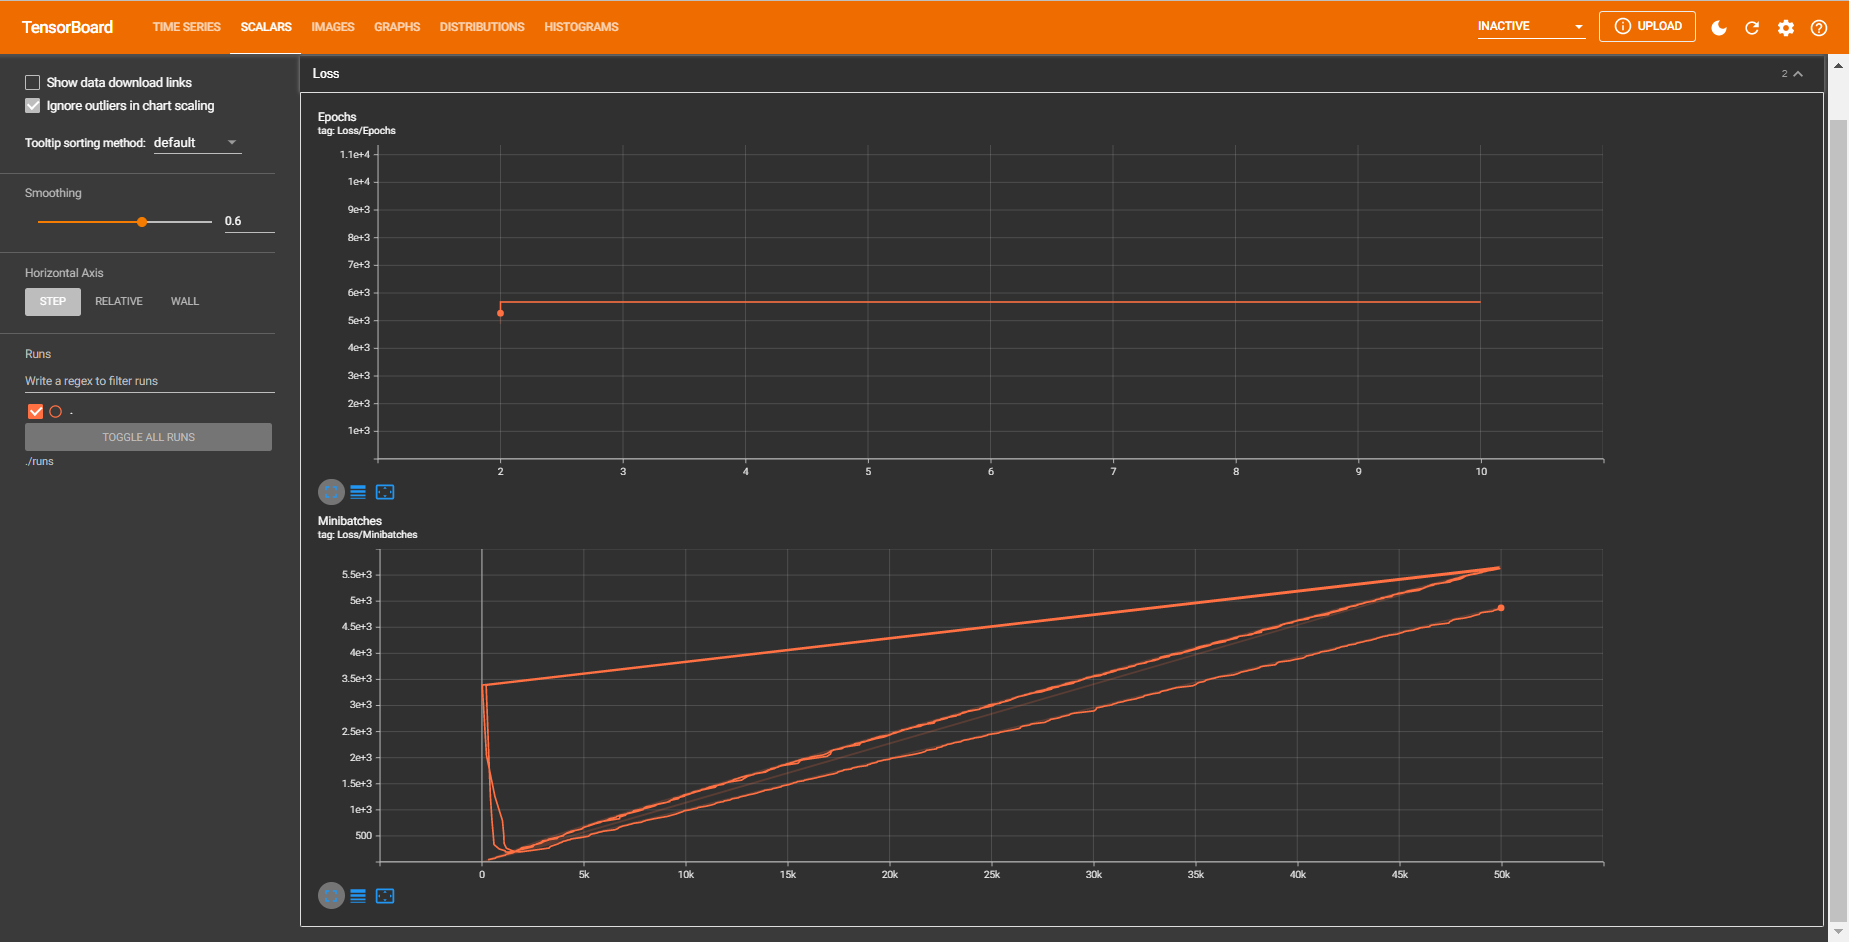

#### graph
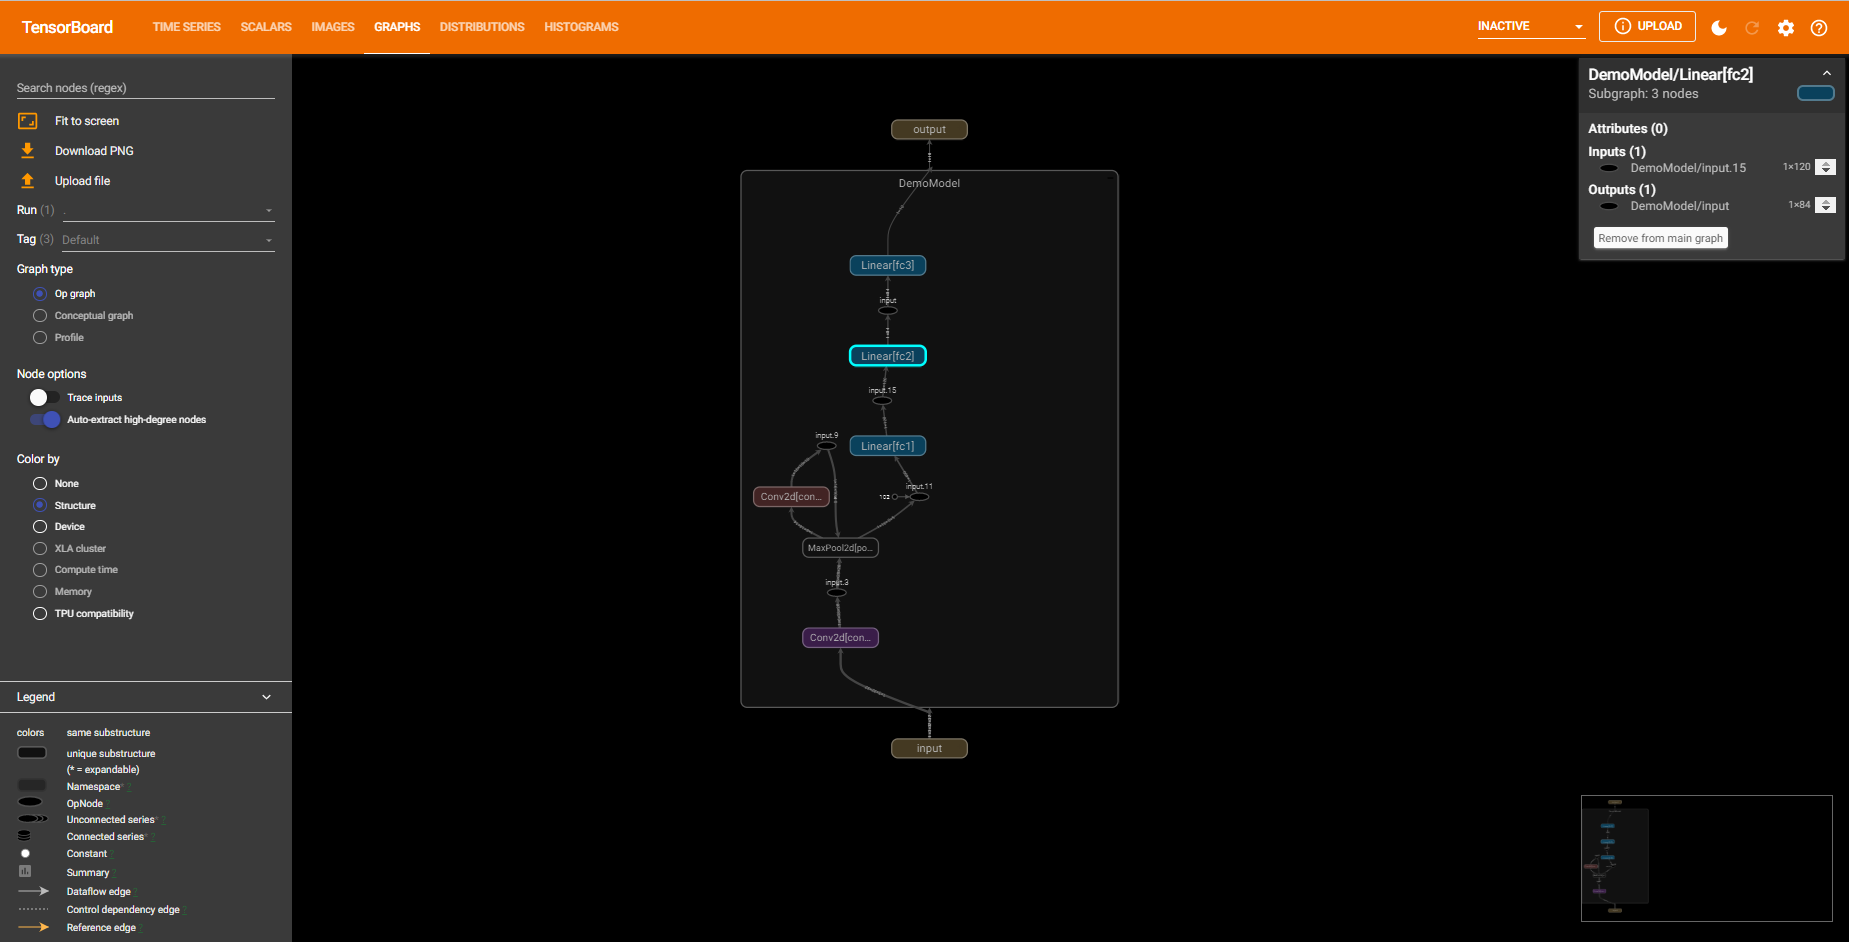
